In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("CHF=X.csv")
df.head(6)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,1.1378,1.1550,1.1374,1.1470,1.1470,0.0
1,2005-01-04,1.1471,1.1706,1.1443,1.1676,1.1676,0.0
2,2005-01-05,1.1676,1.1754,1.1655,1.1669,1.1669,0.0
3,2005-01-06,1.1672,1.1773,1.1667,1.1740,1.1740,0.0
4,2005-01-07,1.1740,1.1885,1.1676,1.1841,1.1841,0.0
5,2005-01-10,1.1837,1.1848,1.1785,1.1794,1.1794,0.0


## Inspect data 

In [4]:
df[df.Close.isnull()]

,Date,Open,High,Low,Close,Adj Close,Volume
187,2005-09-21,NaN,NaN,NaN,NaN,NaN,NaN
700,2007-09-10,NaN,NaN,NaN,NaN,NaN,NaN
755,2007-11-26,NaN,NaN,NaN,NaN,NaN,NaN
771,2007-12-18,NaN,NaN,NaN,NaN,NaN,NaN
846,2008-04-01,NaN,NaN,NaN,NaN,NaN,NaN
868,2008-05-01,NaN,NaN,NaN,NaN,NaN,NaN
911,2008-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1639,2011-04-15,NaN,NaN,NaN,NaN,NaN,NaN
1844,2012-01-27,NaN,NaN,NaN,NaN,NaN,NaN
1846,2012-01-31,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = df.fillna(method="pad", limit=1)
df[df.Close.isnull()]

,Date,Open,High,Low,Close,Adj Close,Volume


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.0
mean,1.019453,1.023521,1.015348,1.019409,1.019409,0.0
std,0.118467,0.119269,0.117737,0.118455,0.118455,0.0
min,0.722490,0.731100,0.718290,0.722800,0.722800,0.0
25%,0.933635,0.937180,0.930485,0.933660,0.933660,0.0
50%,0.984100,0.987200,0.980500,0.984000,0.984000,0.0
75%,1.076650,1.084300,1.071700,1.076750,1.076750,0.0
max,1.324600,1.328300,1.317100,1.324800,1.324800,0.0


In [7]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import tqdm 
from sklearn.preprocessing import MinMaxScaler

In [8]:


train_x = []
train_y = []
test_x = []
test_y = []

# Define lookback period and split inputs/labels
lookback = 10
lookforward = 5
inputs = np.zeros((len(df)-lookback-lookforward, lookback, 1))
labels = np.zeros((len(df)-lookback-lookforward, lookforward))

for i in range(lookback+lookforward, len(df)):
    inputs[i-lookback-lookforward] = df.Close.iloc[i-lookback-lookforward:i-lookforward].values.reshape(-1,1)
    labels[i-lookback-lookforward] = df.Close.iloc[i-lookforward:i]
inputs = inputs.reshape(-1,lookback,1)
labels = labels.reshape(-1,lookforward)

# Split data into train/test portions 
test_portion = int(0.1*len(inputs))

train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]

test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]


In [9]:
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [10]:
is_cuda = torch.cuda.is_available()
print("is_cuda:", is_cuda)
# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

is_cuda: False


In [11]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv1d(1, 16, 3, padding=1)
      self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
      self.conv3 = nn.Conv1d(32, 64, 5, padding=2)
      self.dropout1 = nn.Dropout(0.25)
      self.dropout2 = nn.Dropout(0.25)
      self.dropout3 = nn.Dropout(0.25)
      self.dropout4 = nn.Dropout(0.25)
      self.fc1 = nn.Linear(320,320)
      self.fc2 = nn.Linear(320,64)
      self.fc3 = nn.Linear(64,32)
      self.fc4 = nn.Linear(32, 1)

    # x represents our data
    def forward(self, x):
      # Pass data through conv
      x = self.conv1(x)
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)

      x = self.conv3(x)
      x = F.relu(x)

      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)

      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)

      x = self.fc2(x)
      x = F.relu(x)
      x = self.dropout3(x)

      x = self.fc3(x)
      x = F.relu(x)
      x = self.dropout4(x)

      output = self.fc4(x)
      
      return output
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [35]:
def train(train_loader, learn_rate, hidden_dim=256, n_layers= 6, EPOCHS=15, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]

    output_dim = lookforward
    
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.LBFGS(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    counter = 0
    for epoch in tqdm.tqdm(range(1,EPOCHS+1)):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter += 1
        for x, label in train_loader:
      
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            out, h = model(x.to(device).float(), h)

            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
     
            
            #print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
                
        current_time = time.process_time()
        if counter%10 == 0:
            print(out[0], label[0])
            print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        #print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs = out.cpu().detach().numpy()[:,4].reshape(-1)
    targets = labs.numpy()[:, 0].reshape(-1)
    print("Evaluation Time: {}".format(str(time.process_time()-start_time)))

    sMAPE = np.mean(abs(outputs-targets)/(targets+outputs)/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [36]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU",hidden_dim=256,n_layers =2, EPOCHS=5)
#Lstm_model = train(train_loader, lr, model_type="LSTM")

Starting Training of GRU model


  0%|          | 0/5 [00:00<?, ?it/s]


UnboundLocalError: local variable 'h' referenced before assignment

In [25]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, train_x, train_y)

Evaluation Time: 1.7271400000000057
sMAPE: 0.0020646474653079885%


()

In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(Lstm_model, test_x, test_y)

Evaluation Time: 0.49297200000000885
sMAPE: 0.005875876364251097%


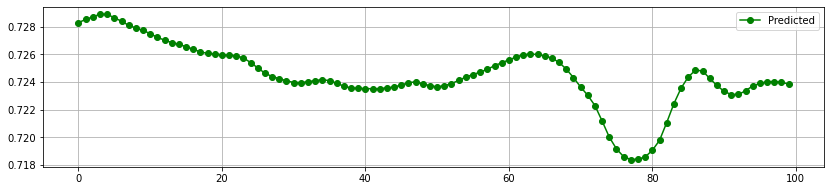

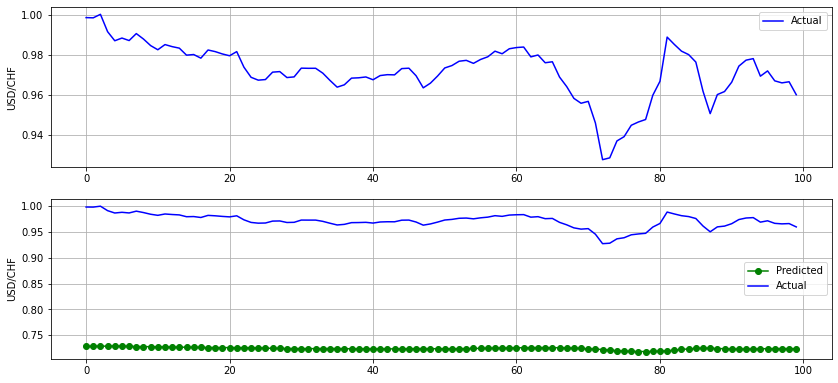

In [26]:
plt.figure(figsize=(14,10))
plt.subplot(3,1,1)
plt.plot(gru_outputs[-100:], "-o", color="g", label="Predicted")
plt.grid()
plt.legend()
plt.figure(figsize=(14,10))
plt.subplot(3,1,2)
plt.plot(targets[-100:], color="b", label="Actual")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()
plt.subplot(3,1,3)
plt.plot(gru_outputs[-100:], "-o", color="g", label="Predicted")
plt.plot(targets[-100:], color="b", label="Actual")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()




In [240]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv1d(1, 16, 3, padding=1)
      self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
      self.conv3 = nn.Conv1d(32, 64, 5, padding=2)
      self.dropout1 = nn.Dropout(0.25)
      self.dropout2 = nn.Dropout(0.25)
      self.dropout3 = nn.Dropout(0.25)
      self.dropout4 = nn.Dropout(0.25)
      self.fc1 = nn.Linear(320,320)
      self.fc2 = nn.Linear(320,64)
      self.fc3 = nn.Linear(64,32)
      self.fc4 = nn.Linear(32, 1)

    # x represents our data
    def forward(self, x):
      # Pass data through conv
      x = self.conv1(x)
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)

      x = self.conv3(x)
      x = F.relu(x)

      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)

      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)

      x = self.fc2(x)
      x = F.relu(x)
      x = self.dropout3(x)

      x = self.fc3(x)
      x = F.relu(x)
      x = self.dropout4(x)

      output = self.fc4(x)
      
      return output



In [241]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=15, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]

    model = Net()
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    counter = 0
    for epoch in tqdm.tqdm(range(1,EPOCHS+1)):
        start_time = time.process_time()
        avg_loss = 0
        counter += 1
        for x, label in train_loader:
            
            model.zero_grad()
           
            out = model(x.to(device).float().unsqueeze(1).squeeze(-1))

            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
                #print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
                
        current_time = time.process_time()
        if counter%100 == 0:
            print(out[0], label[0])
            print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        #print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
   
    out = model(inp.to(device).float().unsqueeze(1).squeeze(-1))
    outputs = out.cpu().detach().numpy().reshape(-1)
    targets = labs.numpy().reshape(-1)
    print("Evaluation Time: {}".format(str(time.process_time()-start_time)))

    sMAPE = np.mean(abs(outputs-targets)/(targets+outputs)/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [242]:
lr = 0.001
net_model = train(train_loader, lr, EPOCHS=500)

Starting Training of GRU model


 20%|██        | 101/500 [00:10<00:41,  9.66it/s]

tensor([1.0873], grad_fn=<SelectBackward0>) tensor([0.9836], dtype=torch.float64)
Epoch 100/500 Done, Total Loss: 0.022812053561210632


 40%|████      | 201/500 [00:21<00:30,  9.71it/s]

tensor([0.7533], grad_fn=<SelectBackward0>) tensor([1.0174], dtype=torch.float64)
Epoch 200/500 Done, Total Loss: 0.016145204504330952


 60%|██████    | 301/500 [00:32<00:23,  8.63it/s]

tensor([1.1618], grad_fn=<SelectBackward0>) tensor([0.9678], dtype=torch.float64)
Epoch 300/500 Done, Total Loss: 0.011583500541746616


 80%|████████  | 401/500 [00:43<00:10,  9.55it/s]

tensor([0.9040], grad_fn=<SelectBackward0>) tensor([0.9891], dtype=torch.float64)
Epoch 400/500 Done, Total Loss: 0.009204554681976637


100%|██████████| 500/500 [00:53<00:00,  9.27it/s]

tensor([1.2343], grad_fn=<SelectBackward0>) tensor([1.2169], dtype=torch.float64)
Epoch 500/500 Done, Total Loss: 0.007633282182117303
Total Training Time: 61.526655999997956 seconds


In [243]:
net_m, targets, gru_sMAPE = evaluate(net_model, train_x, train_y)

Evaluation Time: 0.04669499999999971
sMAPE: 6.665528611772609e-05%


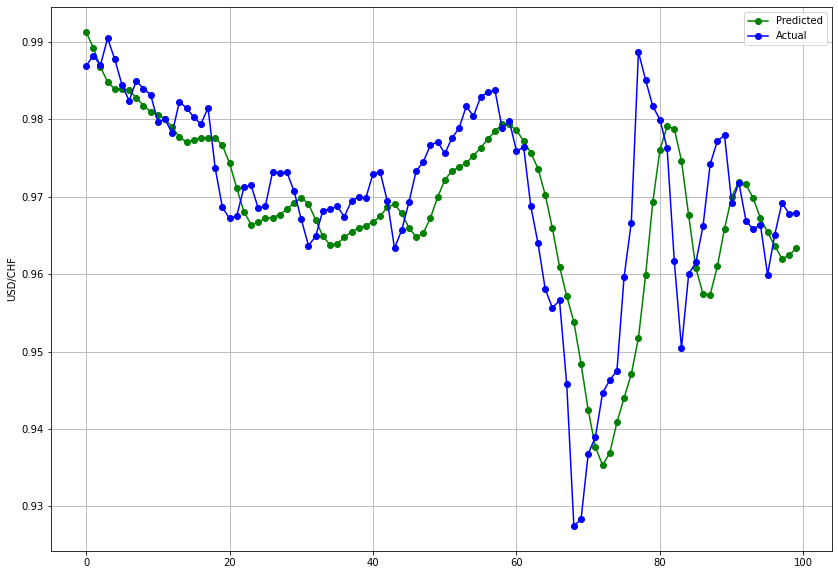

In [254]:
plt.figure(figsize=(14,10))
plt.plot(net_m[-100:], "-o", color="g", label="Predicted")
plt.plot(targets[-100:],"-o", color="b", label="Actual")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()


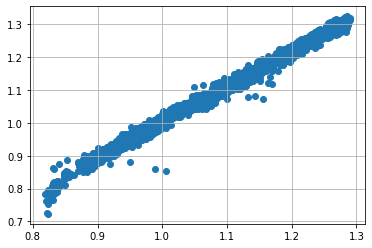

In [247]:
plt.scatter(net_m, targets)
plt.grid()

In [250]:
((net_m - targets)**2).sum()/len(net_m)

0.0002294206288229455